In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Este código fue tomado del siguiente repositorio: https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb
Los invito a que saquen provecho de la manera en la que el autor estructura su código, ya que, bien utilizado, les puede servir para otros problemas. Sobre todo, tómense el tiempo de entender el Data Generator, ese módulo pueden adaptarlo para diferentes tareas.

# **Descomprimimos la base de datos (unzip)**

In [14]:
from zipfile import ZipFile
cont = 0
file_name = '/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 10/UNet/stage1_train.zip'.format(cont)
with ZipFile(file_name, 'r') as zip: 
  zip.extractall('stage1_train')

In [15]:
## Importaciones
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

## Seeding (así se obtienen resultados reproducibles)
seed = 2020
random.seed = seed
np.random.seed = seed
tf.seed = seed

# **Data generator**

In [16]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size, image_size, shuffle):   # Init: Palabra reservada, dice que los valores se inicializan de forma automatica
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Ruta de la base de datos
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Imagen de entrada
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Máscaras de entrada
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalización
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):                                  # Getitem: Palabra reservada, obtener y proporciona imagen y etiqueta(en este caso una imagen)

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        ids_arr = np.asarray(self.ids)
        files_batch = ids_arr[indexes]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):                                          # On epoch end: Al final de cada epoca, los datos se organizan de forma aleatoria, evitando sezgar el modelo 
      self.indexes = np.arange(len(self.ids))
      if self.shuffle == True:
        np.random.shuffle(self.indexes)
        pass
    
    def __len__(self):                                               # Numero de lotes que se van a procesar cada epoca
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

# **Hyperparameters**

In [17]:
image_size = 128
train_path = "stage1_train/"
epochs = 5
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]    #Permite almacenar el nombre de las carpetas en la ruta

## Tamaño del conjunto de validación
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [ ]:
train_ids

In [19]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size, shuffle=True)
x, y = gen.__getitem__(81)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


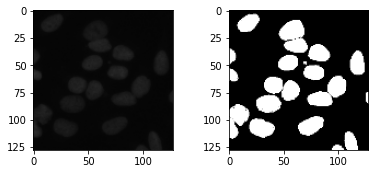

In [20]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

# **Different Convolutional Blocks**

In [21]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

# **UNet model**

In [22]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

# **Compilation of the model**

In [23]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

# **Training the model**

In [24]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size, shuffle=True)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size, shuffle=False)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

mc = ModelCheckpoint('/content/segmentation_model1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs, callbacks=[mc])

Epoch 1/5
82/82 [==============================] - 61s 344ms/step - loss: 0.3874 - acc: 0.8391 - val_loss: 0.2549 - val_acc: 0.8314

Epoch 00001: val_acc improved from -inf to 0.83136, saving model to /content/segmentation_model1.h5
Epoch 2/5
82/82 [==============================] - 27s 331ms/step - loss: 0.2078 - acc: 0.8634 - val_loss: 0.2177 - val_acc: 0.8939

Epoch 00002: val_acc improved from 0.83136 to 0.89385, saving model to /content/segmentation_model1.h5
Epoch 3/5
82/82 [==============================] - 26s 325ms/step - loss: 0.1341 - acc: 0.9336 - val_loss: 0.1844 - val_acc: 0.9101

Epoch 00003: val_acc improved from 0.89385 to 0.91008, saving model to /content/segmentation_model1.h5
Epoch 4/5
82/82 [==============================] - 28s 346ms/step - loss: 0.1141 - acc: 0.9402 - val_loss: 0.1615 - val_acc: 0.9140

Epoch 00004: val_acc improved from 0.91008 to 0.91402, saving model to /content/segmentation_model1.h5
Epoch 5/5
82/82 [==============================] - 28s 347m

In [ ]:
#Copy save model to Google Drive
import shutil
shutil.copyfile('/content/segmentation_model1.h5', '/content/drive/My Drive/G3_AI_Lab_School/Sesion_10/UNet/segmentation_model1.h5')

'/content/drive/My Drive/G3_AI_Lab_School/Sesion_10/UNet/segmentation_model1.h5'

# **Testing the model**

In [12]:
# Load the model
model = keras.models.load_model('/content/drive/My Drive/G3_AI_Lab_School/Sesion_10/UNet/segmentation_model1.h5', compile=False)

OSError: ignored

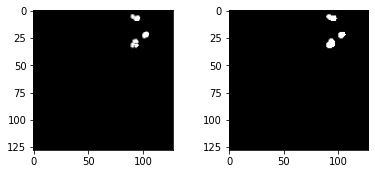

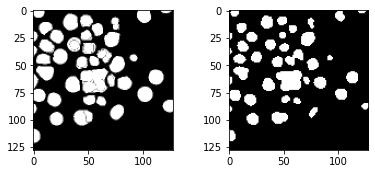

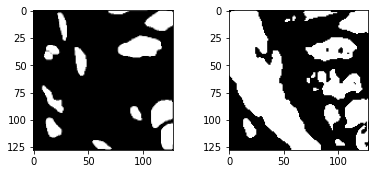

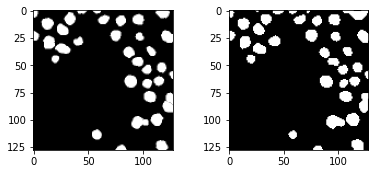

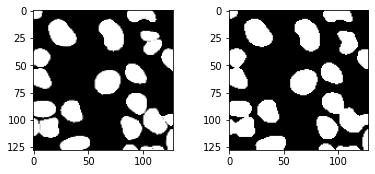

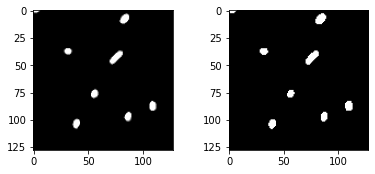

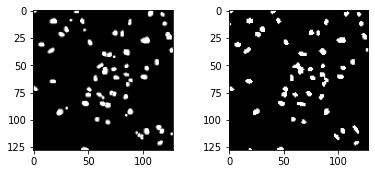

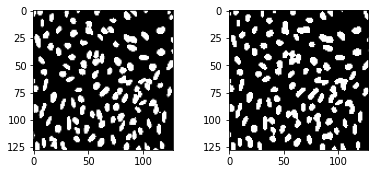

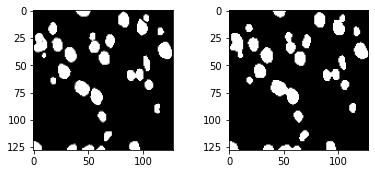

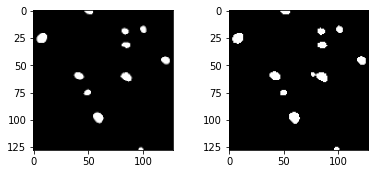

In [25]:
## Dataset for prediction
for i in range(valid_steps+1):
  x, y = valid_gen.__getitem__(i)

  for j in range(len(x)):
    result = model.predict(x)

    result = result > 0.5

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.reshape(y[j]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.reshape(result[j]*255, (image_size, image_size)), cmap="gray")